In [1]:
import numpy as np
import cudf
from cuml.cluster import DBSCAN
from cuml.metrics.cluster import silhouette_score
from sklearn.metrics import davies_bouldin_score

/home/hice1/ltupac3/scratch/testpy/lib/python3.9/site-packages/cupy/_environment.py:541: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


In [2]:
def run_dbscan_clustering(file_path, eps=1.2, min_samples=50):
    """
    Loads precomputed article embeddings and applies GPU-accelerated DBSCAN clustering.

    Args:
        file_path (str): Path to the saved `.npy` file containing article vectors.
        eps (float): DBSCAN parameter for neighborhood size.
        min_samples (int): Minimum points required to form a dense region.

    Returns:
        cudf.Series: Cluster labels for each article.
    """
    # print(f"Loading article vectors from {file_path}...")
    article_vectors = np.load(file_path)
    # print(f"Loaded {article_vectors.shape[0]} articles, each with {article_vectors.shape[1]} dimensions.")

    # Convert NumPy array to cuDF DataFrame for GPU acceleration
    df_vectors = cudf.DataFrame(article_vectors)

    # print("Running GPU-accelerated DBSCAN clustering...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", output_type="cudf")
    cluster_labels = dbscan.fit_predict(df_vectors)

    # Convert cluster labels to a standard Pandas array
    cluster_labels = cluster_labels.to_pandas().values

    # Evaluate clustering quality
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    noise_ratio = (cluster_labels == -1).sum() / len(cluster_labels)

    print(f"Found {num_clusters} clusters.")
    print(f"Noise points: {100 * noise_ratio:.2f}% of data.")
    
    silhouette, db_index = None, None
    if num_clusters > 1:
        silhouette = silhouette_score(df_vectors, cluster_labels)
        db_index = davies_bouldin_score(article_vectors, cluster_labels)
        # print(f"Silhouette Score: {silhouette:.4f}")
        # print(f"Davies-Bouldin Index: {db_index:.4f}")

    print("Clustering complete.")
    return cluster_labels, num_clusters, noise_ratio, silhouette, db_index

In [5]:
# Run DBSCAN on your saved embeddings
DIR = "Word2Vec/"
file_path = DIR + "retry/word2vec_financial_news_400_4.npy"

Running DBSCAN with eps=1.0...
[W] [20:52:54.006795] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance
Found 61 clusters.
Noise points: 38.67% of data.
Clustering complete.
Running DBSCAN with eps=1.2...
[W] [20:53:28.208928] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance
Found 14 clusters.
Noise points: 8.10% of data.
Clustering complete.
Running DBSCAN with eps=1.4...
[W] [20:53:59.045632] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance
Found 2 clusters.
Noise points: 1.20% of data.
Clustering complete.
Running DBSCAN with eps=1.6...
[W] [20:54:31.733336] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance
Found 1 clusters.
Noise points: 0

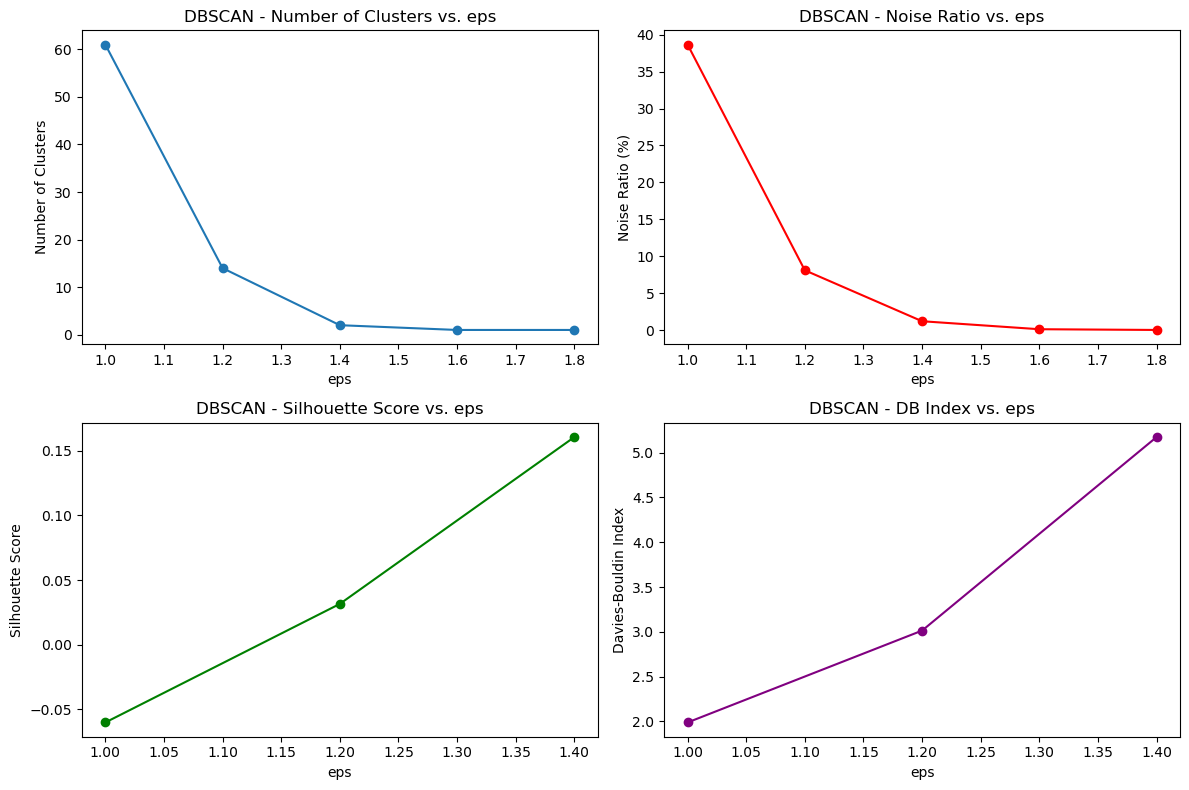

In [6]:
# Run DBSCAN over a range of eps values
eps_values = [1.0, 1.2, 1.4, 1.6, 1.8]
num_clusters_list = []
noise_ratio_list = []
silhouette_scores = []
db_indices = []

for eps in eps_values:
    print(f"Running DBSCAN with eps={eps}...")
    _, num_clusters, noise_ratio, silhouette, db_index = run_dbscan_clustering(file_path, eps=eps, min_samples=50)

    num_clusters_list.append(num_clusters)
    noise_ratio_list.append(noise_ratio)
    silhouette_scores.append(silhouette)
    db_indices.append(db_index)

# Convert lists to NumPy arrays for plotting
eps_values = np.array(eps_values)
num_clusters_list = np.array(num_clusters_list)
noise_ratio_list = np.array(noise_ratio_list)
silhouette_scores = np.array(silhouette_scores, dtype=np.float32)
db_indices = np.array(db_indices, dtype=np.float32)

import matplotlib.pyplot as plt

# Plot Results
plt.figure(figsize=(12, 8))

# Number of Clusters
plt.subplot(2, 2, 1)
plt.plot(eps_values, num_clusters_list, marker='o', linestyle='-')
plt.xlabel("eps")
plt.ylabel("Number of Clusters")
plt.title("DBSCAN - Number of Clusters vs. eps")

# Noise Ratio
plt.subplot(2, 2, 2)
plt.plot(eps_values, noise_ratio_list * 100, marker='o', linestyle='-', color='red')
plt.xlabel("eps")
plt.ylabel("Noise Ratio (%)")
plt.title("DBSCAN - Noise Ratio vs. eps")

# Silhouette Score
plt.subplot(2, 2, 3)
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-', color='green')
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.title("DBSCAN - Silhouette Score vs. eps")

# Davies-Bouldin Index
plt.subplot(2, 2, 4)
plt.plot(eps_values, db_indices, marker='o', linestyle='-', color='purple')
plt.xlabel("eps")
plt.ylabel("Davies-Bouldin Index")
plt.title("DBSCAN - DB Index vs. eps")

plt.tight_layout()
plt.show()

In [7]:
article_vectors = np.load(file_path)
df_vectors = cudf.DataFrame(article_vectors)
dbscan = DBSCAN(eps=1.2, min_samples=50, metric="euclidean", output_type="cudf")
cluster_labels = dbscan.fit_predict(df_vectors)

[W] [20:55:25.097815] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance


In [8]:
# Convert cluster labels to Pandas for easier analysis
cluster_labels = cluster_labels.to_pandas()

# Get cluster distribution
cluster_counts = cluster_labels.value_counts().sort_index()

print("Cluster Distribution:")
print(cluster_counts)


Cluster Distribution:
-1      20980
 0     232139
 1       1200
 2       1048
 3        543
 4        102
 5       1035
 6        557
 7        369
 8        260
 9        198
 10       310
 11       156
 12       171
 13        73
Name: count, dtype: int64


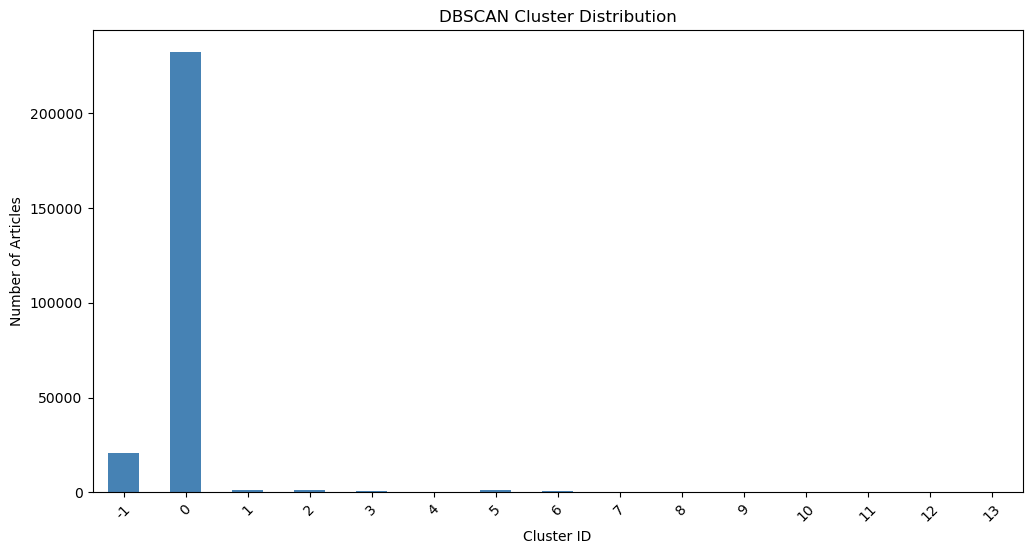

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
cluster_counts.plot(kind="bar", color="steelblue")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Articles")
plt.title("DBSCAN Cluster Distribution")
plt.xticks(rotation=45)
plt.show()


In [11]:
import pandas as pd

# Load article vectors
article_vectors = np.load("Word2Vec/retry/word2vec_financial_news_400_4.npy")

# Run DBSCAN one final time with min_samples = 100
dbscan = DBSCAN(eps=1.2, min_samples=100, metric="euclidean", output_type="cudf")
df_vectors = cudf.DataFrame(article_vectors)
# cluster_labels = dbscan.fit_predict(df_vectors).to_pandas()

# cluster_labels.to_csv("scratch/Word2Vec/csv/cluster_labels.csv")

cluster_labels = dbscan.fit_predict(df_vectors).to_pandas().values  # Convert to NumPy
data_with_clusters = np.hstack((article_vectors, cluster_labels.reshape(-1, 1)))
# np.save("scratch/Word2Vec/np/article_vectors_with_clusters.npy", data_with_clusters)

[W] [20:56:39.720010] Batch size limited by the chosen integer type (4 bytes). 20715 -> 8286. Using the larger integer type might result in better performance


# Experimenting with sub-clustering

In [14]:
import numpy as np
import cudf
import matplotlib.pyplot as plt
from cuml.cluster import DBSCAN
from cuml.metrics.cluster import silhouette_score
from sklearn.metrics import davies_bouldin_score

# Load dataset with cluster labels
data_with_clusters = np.load("Word2Vec/np/article_vectors_with_clusters.npy")
article_vectors = data_with_clusters[:, :-1]  # Extract article vectors
cluster_labels = data_with_clusters[:, -1]  # Extract cluster labels

# Extract only articles from Cluster 0
cluster_0_indices = np.where(cluster_labels == 0)[0]
cluster_0_vectors = article_vectors[cluster_0_indices]

print(f"Extracted {cluster_0_vectors.shape[0]} articles from Cluster 0 for sub-clustering.")

# Define DBSCAN parameters to test
eps_values = [0.5, 0.7, 0.9, 1.1, 1.3]
min_samples_values = [30, 40, 50]  # Reduced upper bound for finer granularity

# Store results
results = []

# Grid search over eps and min_samples
for eps in eps_values:
    for min_samples in min_samples_values:
        print(f"Running DBSCAN for sub-clustering (eps={eps}, min_samples={min_samples})...")

        # Convert to cuDF for GPU acceleration
        df_vectors = cudf.DataFrame(cluster_0_vectors)

        # Run DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="euclidean", output_type="cudf")
        sub_cluster_labels = dbscan.fit_predict(df_vectors).to_pandas().values  # Convert to NumPy

        # Count clusters
        num_sub_clusters = len(set(sub_cluster_labels)) - (1 if -1 in sub_cluster_labels else 0)
        noise_ratio = (sub_cluster_labels == -1).sum() / len(sub_cluster_labels)

        silhouette, db_index = None, None
        if num_sub_clusters > 1:
            silhouette = silhouette_score(df_vectors, sub_cluster_labels)
            db_index = davies_bouldin_score(cluster_0_vectors, sub_cluster_labels)

        results.append((eps, min_samples, num_sub_clusters, noise_ratio, silhouette, db_index))

# Convert results to NumPy array for plotting
results = np.array(results, dtype=object)

# Extract values for plotting
eps_values_plot = results[:, 0].astype(float)
min_samples_plot = results[:, 1].astype(float)
num_clusters_plot = results[:, 2].astype(int)
noise_ratio_plot = results[:, 3].astype(float)
silhouette_plot = results[:, 4].astype(float)
db_index_plot = results[:, 5].astype(float)

Extracted 227419 articles from Cluster 0 for sub-clustering.
Running DBSCAN for sub-clustering (eps=0.5, min_samples=30)...
[W] [20:57:35.963340] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance
Running DBSCAN for sub-clustering (eps=0.5, min_samples=40)...
[W] [20:58:17.534867] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance
Running DBSCAN for sub-clustering (eps=0.5, min_samples=50)...
[W] [20:58:59.908051] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance
Running DBSCAN for sub-clustering (eps=0.7, min_samples=30)...
[W] [20:59:46.438121] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance
Running DBSCAN for sub-clustering (eps=0.7, min_sam

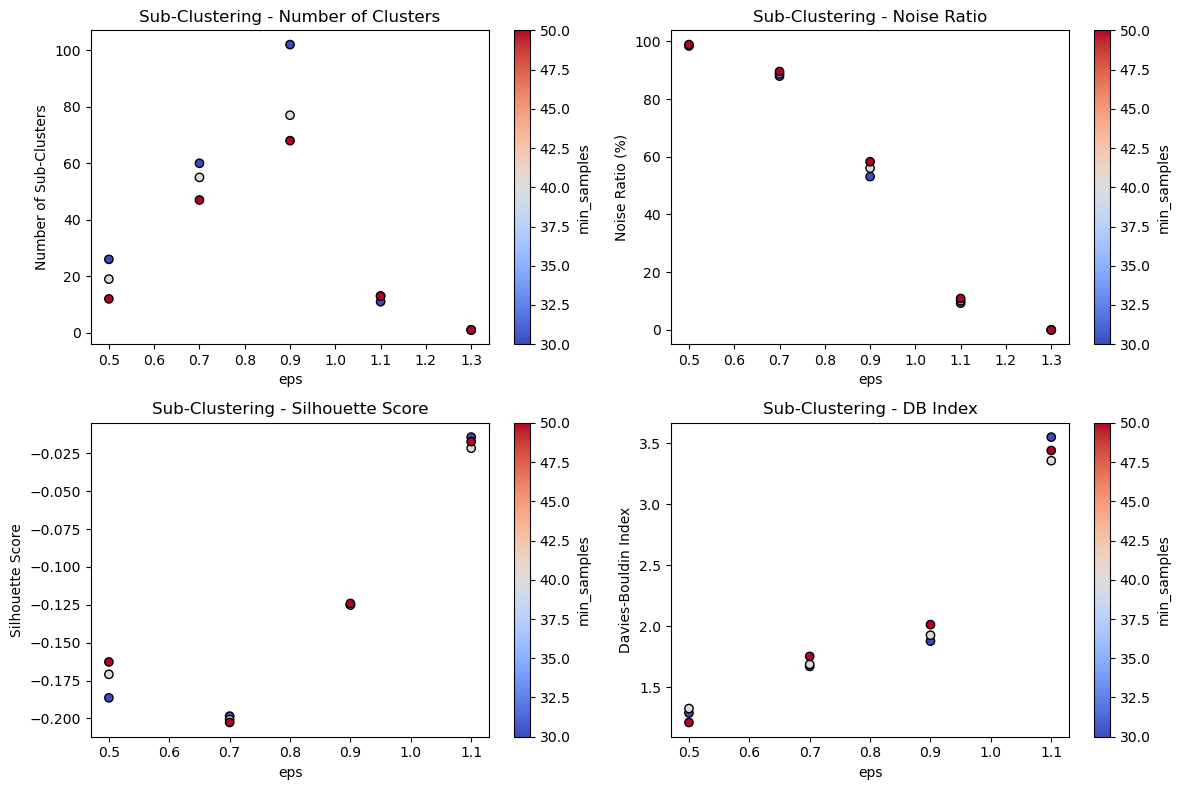

In [15]:
# Plot results
plt.figure(figsize=(12, 8))

# Number of Clusters
plt.subplot(2, 2, 1)
plt.scatter(eps_values_plot, num_clusters_plot, c=min_samples_plot, cmap='coolwarm', edgecolors='k')
plt.xlabel("eps")
plt.ylabel("Number of Sub-Clusters")
plt.colorbar(label="min_samples")
plt.title("Sub-Clustering - Number of Clusters")

# Noise Ratio
plt.subplot(2, 2, 2)
plt.scatter(eps_values_plot, noise_ratio_plot * 100, c=min_samples_plot, cmap='coolwarm', edgecolors='k')
plt.xlabel("eps")
plt.ylabel("Noise Ratio (%)")
plt.colorbar(label="min_samples")
plt.title("Sub-Clustering - Noise Ratio")

# Silhouette Score
plt.subplot(2, 2, 3)
plt.scatter(eps_values_plot, silhouette_plot, c=min_samples_plot, cmap='coolwarm', edgecolors='k')
plt.xlabel("eps")
plt.ylabel("Silhouette Score")
plt.colorbar(label="min_samples")
plt.title("Sub-Clustering - Silhouette Score")

# Davies-Bouldin Index
plt.subplot(2, 2, 4)
plt.scatter(eps_values_plot, db_index_plot, c=min_samples_plot, cmap='coolwarm', edgecolors='k')
plt.xlabel("eps")
plt.ylabel("Davies-Bouldin Index")
plt.colorbar(label="min_samples")
plt.title("Sub-Clustering - DB Index")

plt.tight_layout()
plt.show()


[W] [21:08:14.689817] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance
Sub-Cluster Distribution:
-1      67633
 0     127145
 1       1248
 2       3950
 3       1669
 4       5055
 5        265
 6        209
 7       3521
 8       2770
 9       1867
 10       521
 11       575
 12       526
 13       655
 14       133
 15      1576
 16       163
 17       591
 18       512
 19      1239
 20       624
 21       365
 22        85
 23       738
 24       595
 25        48
 26       874
 27       171
 28        63
 29       168
 30       121
 31       457
 32       170
 33        49
 34       183
 35       191
 36       193
 37        45
 38        50
 39        61
 40        76
 41        51
 42        57
 43        47
 44        60
 45        54
Name: count, dtype: int64


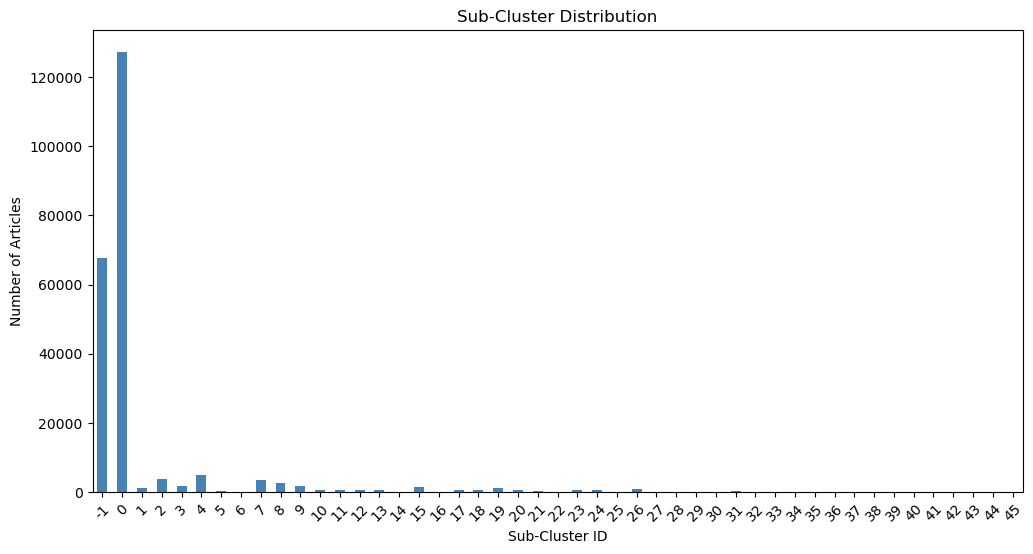

In [16]:
best_eps = 1.0
best_min_samples = 37

best_dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples, metric="euclidean", output_type="cudf")
df_vectors = cudf.DataFrame(cluster_0_vectors)
sub_cluster_labels = best_dbscan.fit_predict(df_vectors).to_pandas().values

# Get cluster distribution
sub_cluster_counts = pd.Series(sub_cluster_labels).value_counts().sort_index()

print("Sub-Cluster Distribution:")
print(sub_cluster_counts)

plt.figure(figsize=(12, 6))
sub_cluster_counts.plot(kind="bar", color="steelblue")
plt.xlabel("Sub-Cluster ID")
plt.ylabel("Number of Articles")
plt.title("Sub-Cluster Distribution")
plt.xticks(rotation=45)
plt.show()


In [17]:
sub_cluster_labels = best_dbscan.fit_predict(df_vectors).to_pandas().values  # Convert back to NumPy

# Ensure sub-cluster labels are unique (avoid overlap with original DBSCAN)
sub_cluster_labels = sub_cluster_labels + 1000  # Offset labels to prevent duplication
sub_cluster_labels[sub_cluster_labels == 999] = -1  # Keep noise as -1

# Replace Cluster 0 labels in the original dataset
updated_cluster_labels = cluster_labels.copy()
updated_cluster_labels[cluster_0_indices] = sub_cluster_labels

# Save updated dataset
final_data_with_clusters = np.column_stack((article_vectors, updated_cluster_labels))
np.save("scratch/Word2Vec/np/article_vectors_final_clusters.npy", final_data_with_clusters)

print("Sub-clustered data saved as 'article_vectors_final_clusters.npy'")


[W] [21:08:41.632327] Batch size limited by the chosen integer type (4 bytes). 23330 -> 9442. Using the larger integer type might result in better performance


FileNotFoundError: [Errno 2] No such file or directory: 'scratch/Word2Vec/np/article_vectors_final_clusters.npy'

In [ ]:
for i in final_data_with_clusters[:, -1]:
    print(i)

1000.0
-1.0
-1.0
-1.0
1004.0
-1.0
-1.0
1000.0
1000.0
1000.0
-1.0
1000.0
1000.0
1000.0
3.0
-1.0
1000.0
1000.0
1000.0
1001.0
-1.0
-1.0
1000.0
1002.0
1000.0
-1.0
-1.0
-1.0
1000.0
1000.0
1003.0
1000.0
3.0
1000.0
1000.0
-1.0
1000.0
-1.0
1000.0
-1.0
1000.0
1000.0
1000.0
-1.0
1000.0
1000.0
16.0
15.0
1000.0
-1.0
1000.0
1004.0
1000.0
-1.0
-1.0
-1.0
1000.0
1000.0
1000.0
1004.0
1021.0
1000.0
-1.0
-1.0
1002.0
1000.0
1000.0
1000.0
-1.0
1000.0
1000.0
1000.0
1000.0
1002.0
1005.0
1000.0
1000.0
-1.0
1003.0
-1.0
1000.0
1006.0
-1.0
1000.0
1001.0
1000.0
-1.0
1000.0
1000.0
1000.0
1000.0
17.0
1000.0
1000.0
1003.0
-1.0
1.0
1000.0
1000.0
-1.0
1000.0
1000.0
1000.0
-1.0
-1.0
1000.0
-1.0
1000.0
1000.0
1000.0
1000.0
1007.0
1009.0
1000.0
1008.0
1000.0
1020.0
1002.0
-1.0
-1.0
1000.0
1000.0
-1.0
1000.0
1009.0
1000.0
-1.0
1009.0
-1.0
-1.0
1007.0
-1.0
1000.0
-1.0
1007.0
1000.0
1.0
1001.0
-1.0
1000.0
-1.0
-1.0
1000.0
-1.0
-1.0
-1.0
1004.0
1001.0
1000.0
1000.0
-1.0
1000.0
-1.0
1000.0
-1.0
-1.0
-1.0
1000.0
1.0
-1.0
1000.